In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import cv2
import pickle

import warnings
warnings.filterwarnings("ignore")

In [107]:
#load all models
haar = cv2.CascadeClassifier("./Model/haarcascade_frontalface_default.xml")  # haarcascade
model_svm = pickle.load(open("./Model/model_svm.pickle",mode="rb"))  # machine learning model
pca_models = pickle.load(open("./Model/pca_dict.pickle",mode="rb"))  # pca dictionary

In [109]:
pca_models

{'pca': PCA(n_components=50, whiten=True),
 'mean face': array([0.37696499, 0.37400223, 0.37013791, ..., 0.38067117, 0.38036853,
        0.38195715])}

In [111]:
model_pca = pca_models["pca"]
mean_face_arr = pca_models["mean face"]

### Create pipeline

- step 01: Read image
- step 02: Convert into gray scale
- step 03: crop the face (using  haarcascade classifier)
- step 04: normalization(0-1)
- step 05: resize images(100,100)
- step 06: flattening(1x10000)
- step 07: subtract with mean
- step 08: get eigen image
- step 09: eigen image for visualisation
- step 10: pass to ml model(svm) and get predictions
- step 11: Generate  report

In [125]:
img = cv2.imread("./test_images/getty_test.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

faces = haar.detectMultiScale(gray,1.5,3)
prediction = []
for x,y,w,h in faces:
    #cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),3)
    roi = gray[y:y+h,x:x+w]  # crop the image
    
    # plt.imshow(roi,cmap="gray")
    # plt.show()
    roi = roi/255   # normalisation
    # resize images(100,100)
    if roi.shape[1]>100:
        roi_resize = cv2.resize(roi,(100,100),cv2.INTER_AREA)
    else:
        roi_resize = cv2.resize(roi,(100,100),cv2.INTER_CUBIC)

    # flattening images
    roi_reshape = roi_resize.reshape(1,10000)

    # subtract with  mean image
    roi_mean = roi_reshape - mean_face_arr
    # get eigen image
    eigen_image = model_pca.transform(roi_mean)

    #visualise eigen image
    eig_img = model_pca.inverse_transform(eigen_image)

    # pass to ml model and get prediction
    results = model_svm.predict(eigen_image)
    prob_score = model_svm.predict_proba(eigen_image)
    prob_score_max = prob_score.max()
    # print(results,prob_score_max)

    # generate report
    text = "%s : %d"%(results[0],prob_score_max*100)
    # print(text)
    # define color based on results
    if results[0]=="Male":
        color = (255,0,255)
    else:
        color = (255,125,0)
    cv2.rectangle(img,(x,y),(x+w,y+h),color,4)
    cv2.rectangle(img,(x,y-30),(x+w,y),color,-1)
    cv2.putText(img,text,(x,y),cv2.FONT_HERSHEY_PLAIN,3,(255,255,255),2)
    output = {
        "roi":roi,
        "eig_img":eig_img,
        "prediction name":results[0],
        "score":prob_score_max
    }

    prediction.append(output)

In [127]:
prediction

[{'roi': array([[0.54117647, 0.56078431, 0.58823529, ..., 0.64313725, 0.63529412,
          0.63137255],
         [0.58431373, 0.6       , 0.61568627, ..., 0.62352941, 0.63137255,
          0.64313725],
         [0.59607843, 0.61568627, 0.63137255, ..., 0.61568627, 0.62352941,
          0.63137255],
         ...,
         [0.6       , 0.59607843, 0.58039216, ..., 0.9372549 , 0.93333333,
          0.93333333],
         [0.59607843, 0.59215686, 0.57647059, ..., 0.93333333, 0.93333333,
          0.93333333],
         [0.59215686, 0.58823529, 0.57647059, ..., 0.92941176, 0.92941176,
          0.93333333]]),
  'eig_img': array([[0.14959998, 0.15201656, 0.17223585, ..., 0.34187527, 0.35189835,
          0.34879384]]),
  'prediction name': 'Male',
  'score': 0.9927732412695013},
 {'roi': array([[0.6       , 0.60784314, 0.61960784, ..., 0.57254902, 0.57647059,
          0.58039216],
         [0.61568627, 0.61960784, 0.62352941, ..., 0.57254902, 0.57647059,
          0.57647059],
         [0.65

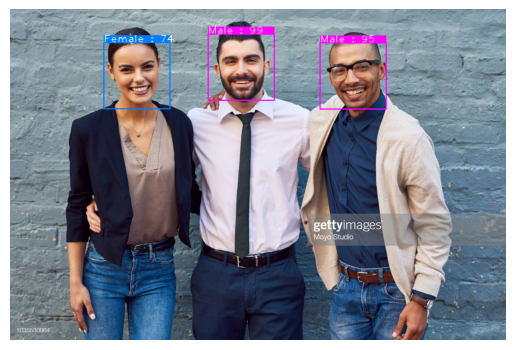

In [129]:
rgb_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)
plt.axis("off")
plt.show()

0


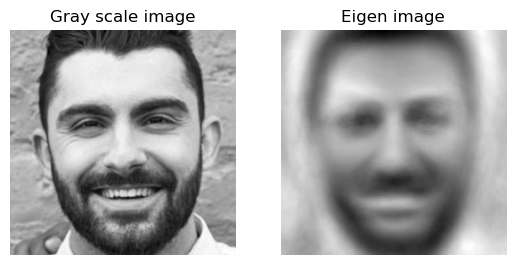

Predicted Gender =  Male
Predicted Score = 99.28 %
----------------------------------------------------------------------------------------------------
1


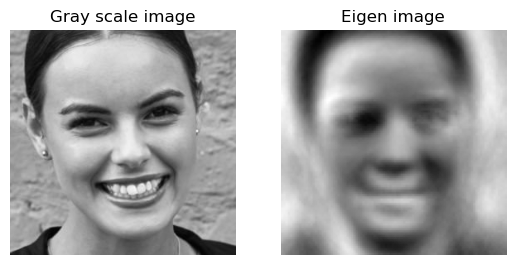

Predicted Gender =  Female
Predicted Score = 74.02 %
----------------------------------------------------------------------------------------------------
2


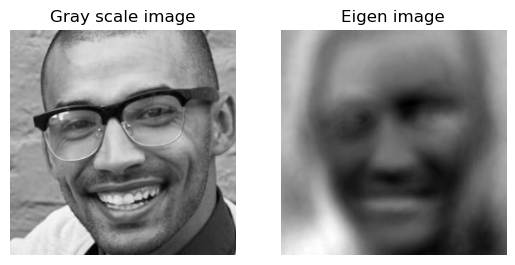

Predicted Gender =  Male
Predicted Score = 95.12 %
----------------------------------------------------------------------------------------------------


In [131]:
#generate report
for i in range(len(prediction)):
    print(i)
    obj_gray = prediction[i]["roi"]  # gray scale
    obj_eig = prediction[i]["eig_img"].reshape(100,100)
    plt.subplot(1,2,1)
    plt.imshow(obj_gray,cmap="gray")
    plt.title("Gray scale image")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(obj_eig,cmap="gray")
    plt.title("Eigen image")
    plt.axis("off")

    plt.show()
    print("Predicted Gender = ",prediction[i]["prediction name"])
    print("Predicted Score = {:,.2f} %".format(prediction[i]["score"]*100))

    print("-"*100)